In [1]:
import pickle
import re
from itertools import compress

import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torchvision.transforms as T
from PIL import Image
from matplotlib.patches import Polygon
from tqdm import tqdm
from matplotlib.patches import Polygon
from skimage.measure import find_contours
from torchvision.ops import nms

In [2]:
segmentation_results_dir = '../data/segmentation_results/'
image_folder = '../data/BCU_database/03_resized/'

In [3]:
dataset = pickle.load(open('../data/dataset_for_segmentation.p', 'rb'))
dataset.head()

,idx,filename,caption,model,expr,conf,bbox,labels,image_id,caption_raw,caption_preprocessed,title_raw,title_preprocessed
0,1027,JOMU_32980_2k_324w.jpg,people buying sweets at the market.,GLIP,caption,"[tensor(0.8280), tensor(0.7924), tensor(0.6899...","[[tensor(178.8594), tensor(116.5122), tensor(2...","[people, people, people, people, people, peopl...",1488.0,people buying sweets at the market.,people buying sweets at the market.,"Saint Nicholas Festival Market, Place de Notre...","saint nicholas festival market, place de notre..."
1,183,CAPO_02480_2k_324w.jpg,a group of soldiers stand in front of a building.,GLIP,caption,"[tensor(0.8242), tensor(0.5884), tensor(0.5781...","[[tensor(0.8775), tensor(131.9302), tensor(81....","[soldiers, a building, a building, a building]",516.0,a group of soldiers stand in front of a building.,a group of soldiers stand in front of a building.,[Mobilization at Perolles in August 1914],[mobilization at perolles in august 1914]
2,543,JATH_26232_2k_324w.jpg,soldiers stand in front of a military vehicle.,GLIP,caption,"[tensor(0.7898), tensor(0.7305), tensor(0.6872...","[[tensor(97.0861), tensor(137.5495), tensor(14...","[soldiers, soldiers, a military vehicle, soldi...",950.0,soldiers stand in front of a military vehicle.,soldiers stand in front of a military vehicle.,"Additional service for women, Barracks de la P...","additional service for women, barracks de la p..."
3,430,JATH_10616_2k_324w.jpg,women walking down a street.,GLIP,caption,"[tensor(0.6900), tensor(0.6777), tensor(0.6676...","[[tensor(125.4207), tensor(111.6184), tensor(1...","[women, women, women, a street, women]",836.0,women walking down a street.,women walking down a street.,Procession on the route to the Alps during a w...,procession on the route to the alps during a w...
4,408,HAWI_01023_2k_324w.jpg,a photograph of a large tropical cyclone.,GLIP,caption,[tensor(0.7263)],"[[tensor(4.5861), tensor(13.1419), tensor(318....",[a large tropical cyclone],814.0,a photograph of a large tropical cyclone.,a a large tropical cyclone.,Tornado over Lake Morat,tornado over lake morat


In [4]:
class FiftyOneTorchDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        df_dataset,
        transforms=None,
        transforms_mask=None,
        images_folder=None,
        desired_size=352
    ):
        self.transforms = transforms
        self.transforms_mask = transforms_mask
        self.df_dataset = df_dataset
        self.images_folder = images_folder
        self.desired_size = desired_size

    def __getitem__(self, idx):
        data = self.df_dataset.loc[idx].copy()
        img_path = self.images_folder + data['filename']
        pilimg = Image.open(img_path).convert("RGB")
        img = np.array(pilimg)
        mask = np.zeros((len(data['bbox']), img.shape[0], img.shape[1]))

        old_size = img.shape[:2]
        ratio = float(self.desired_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        original_img = img.copy()
        img = cv2.resize(img, (new_size[1], new_size[0]))

        delta_w = self.desired_size - new_size[1]
        delta_h = self.desired_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        color = [0, 0, 0]
        img = cv2.copyMakeBorder(
            img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
        )
        new_mask = []
        if len(data['conf']) == 0:
            return {
                'img': img,
                'input': None,
                'mask': None,
                'data': data,
                'scaled_img': None,
            }
        for i, box in enumerate(data['bbox']):
            box[box < 0] = 0
            box = box.int()
            mask[i, box[1] : box[3], box[0] : box[2]] = 1
            new_mask.append(
                cv2.copyMakeBorder(
                    cv2.resize(mask[i], (new_size[1], new_size[0])),
                    top,
                    bottom,
                    left,
                    right,
                    cv2.BORDER_CONSTANT,
                    value=color,
                )
            )
        mask = np.array(new_mask)

        if self.transforms_mask is not None:
            transformed_mask = []
            for i, mask_ in enumerate(mask):
                transformed_mask.append(self.transforms_mask(mask_))
            mask = torch.stack(transformed_mask)
        if self.transforms is not None:
            img = self.transforms(img)

        output = torch.zeros((len(data['bbox']), 3, img.shape[1], img.shape[2]))
        for i, mask_ in enumerate(mask):
            output[i] = img * mask_

        return {
            'original_shape': old_size,
            'input': output,
            'mask': mask,
            'data': data,
            'original_img': original_img,
        }

    def __len__(self):
        return len(self.df_dataset)

In [5]:
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_mask_test = T.Compose([
    T.ToTensor(),
])
dataset_test = FiftyOneTorchDataset(dataset, images_folder=image_folder, transforms=transform_test, transforms_mask = transform_mask_test)

In [12]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933], [0,0,0]]

def apply_mask(image, mask, color, alpha=0.3):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def get_color(label, set_label):
    for i, elem in enumerate(set_label):
        if elem.lower() == label.lower():
            return i
    return 6

from matplotlib.transforms import Affine2D, offset_copy


def rainbow_text(x, y, strings, colors, orientation='horizontal',
                 ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    fig = ax.figure
    canvas = fig.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    return [strings, colors]
    # for s, c in zip(strings, colors):
    #     text = ax.text(x, y, s + " ", color=c, transform=t, **kwargs)

    #     # Need to draw to update the text position.
    #     text.draw(canvas.get_renderer())
    #     ex = text.get_window_extent()
    #     # Convert window extent from pixels to inches
    #     # to avoid issues displaying at different dpi
    #     ex = fig.dpi_scale_trans.inverted().transform_bbox(ex)

    #     if orientation == 'horizontal':
    #         t = text.get_transform() + \
    #             offset_copy(Affine2D(), fig=fig, x=ex.width, y=0)
    #     else:
    #         t = text.get_transform() + \
    #             offset_copy(Affine2D(), fig=fig, x=0, y=ex.height)

def get_title(s, set_label, ax):
    set_label = [label.replace('( ', '(').replace(' )',')') for label in set_label]

    text = [s for s in re.split('(' + ('|').join(set_label).replace('(','\(').replace(')','\)') + ')', s, flags=re.IGNORECASE) if s.strip()]
    colors = []
    for word in text:
        colors.append(COLORS[get_color(word.replace('( ', '(').replace(' )',')'), set_label)])
    # rainbow_text(-100, -30, text, colors, size=12, ax=ax)
    return {'text': text, 'colors': colors}



def plot_results(ax, pil_img, results, expr, masks=None, conf=0.7):
    if results is None:
        return ax
    keep = results['conf'] > conf
    scores = results['conf'][keep]
    boxes = results['bbox'][keep]
    labels = list(compress(results['labels'], keep))
    set_label = set(labels)
    np_image = np.array(pil_img)
    if masks is not None:
        masks = masks[keep]
        # for i, bbox in enumerate(boxes):
        #     if ((bbox[2]-bbox[0]) * (bbox[3]-bbox[1])) / (np_image.shape[0] * np_image.shape[1]) > 0.7:
        #         masks[i] = 0

    colors = COLORS * 100
    if masks is None:
        masks = []
        for bbox in boxes:
            masks.append(None)

    labels = [x for _,x in sorted(zip(boxes[:,0],labels))]
    scores = [x for _,x in sorted(zip(boxes[:,0],scores))]
    masks = [x for _,x in sorted(zip(boxes[:,0],masks),key=lambda x: x[0])]
    boxes = [x for _,x in sorted(zip(boxes[:,0],boxes),key=lambda x: x[0])]

    title = get_title(expr, set_label, ax)
    for s, (xmin, ymin, xmax, ymax), l, mask in zip(scores, boxes, labels, masks):
        c = colors[get_color(l, set_label)]
        # ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
        #                            fill=False, color=c, linewidth=1))

        if mask is None:
            # ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
            #                        fill=False, color=c, linewidth=1))
            continue
        np_image = apply_mask(np_image, mask, c)
        # padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        # padded_mask[1:-1, 1:-1] = mask
        # contours = find_contours(padded_mask, 0.5)
        # for verts in contours:
        #     verts = np.fliplr(verts) - 1
        #     p = Polygon(verts, facecolor="none", edgecolor=c)
        #     ax.add_patch(p)


    ax.imshow(np_image)
    ax.set_xticks([])
    ax.set_yticks([])
    return title

In [13]:




class Model(object):
    def __init__(self, path):
        self.model = torch.load(path)
        self.model = self.model.cuda()
        self.model.eval()
    
    @torch.no_grad()
    def inference(self, data):
        if data['mask'] is None:
            return data, None
        self.model.eval()
        predictions = []
        for img_ in data['input']:
            predictions.append(self.model(img_[None,:,:,:].cuda()).cpu().detach().numpy())
        output = []
        bboxes = []
        for mask, prediction in zip(data['mask'], predictions):
            output.append(mask * prediction[0])
            bboxes.append(self.get_bbox_from_mask(mask[0]))
        output = torch.concat(output)

        if data['original_shape'][0] > data['original_shape'][1]:
            resize = T.Resize(data['original_shape'][0], interpolation=T.InterpolationMode.NEAREST)
            resized_output =resize(output)
            offset = (resized_output.shape[2] - data['original_shape'][1]) // 2
            resized_output = resized_output[:,:,offset:offset+data['original_shape'][1]]
        else:
            resize = T.Resize(data['original_shape'][1], interpolation=T.InterpolationMode.NEAREST)
            resized_output =resize(output)
            offset = (resized_output.shape[1]  - data['original_shape'][0]) // 2
            resized_output = resized_output[:,offset:offset+data['original_shape'][0]]


        return data, resized_output

    def get_bbox_from_mask(self, mask, mask_value = 1):
        mask[mask<0] = 0
        if mask_value is None:
            seg = np.where(mask != 0)
        else:
            seg = np.where(mask == mask_value)
        if seg[0].size <= 0 or seg[1].size <= 0:
            return np.zeros((4,), dtype = int)
        min_x = np.min(seg[1])
        min_y = np.min(seg[0])
        max_x = np.max(seg[1])
        max_y = np.max(seg[0])

        return [min_x, min_y, max_x, max_y]


model = Model('../model/model_segmentation.pth')

  7%|▋         | 99/1454 [00:13<03:03,  7.38it/s]


KeyboardInterrupt: 

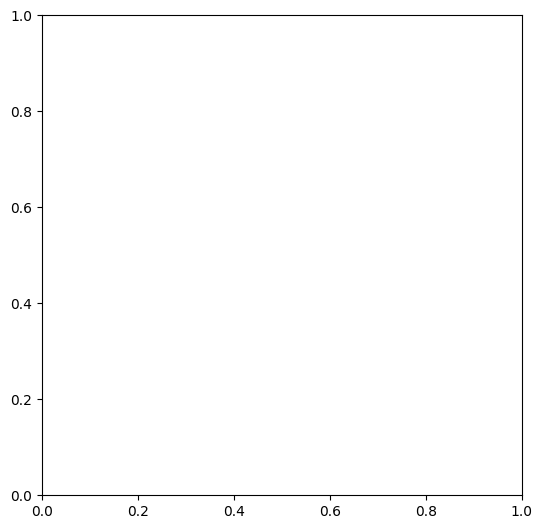

In [14]:
figure = plt.figure()

titles = dict()

for result in tqdm(dataset_test):
    data, mask = model.inference(result)
    if mask is not None:
        img = np.array(Image.open(image_folder + data['data']['filename']).convert("RGB"))

        ax = plt.gca()
        title = plot_results(ax, img.astype(int), data['data'], expr=result['data']['caption'], masks=mask, conf=0)
        titles[result['data']['filename']] = title
        # plt.show()
        plt.tight_layout(pad=0)

        # Save the plot to a file

        plt.savefig(segmentation_results_dir + result['data']['filename'], bbox_inches="tight")
        plt.cla()

import json

# dump titles
with open(segmentation_results_dir + 'titles.json', 'w') as fp:
    json.dump(titles, fp)
    #
    # data['data']['mask'] = mask
    # pickle.dump(data['data'], open(segmentation_results_dir+data['data']['filename'].replace('.jpg','.p'),'wb'))

In [ ]:
import json
with open(segmentation_results_dir + 'titles.json', 'w') as fp:
    json.dump(titles, fp)